### Setting everything up for the notebook

#### Import required libraries

In [1]:
import polars as pl
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

#### Set random seed for reproducibility


In [2]:
SEED = 42
np.random.seed(SEED)

### 1. Load the Jokes with All Features

In [3]:
items = pl.read_parquet("../data/processed/items_with_all_features.parquet")

items.head()

jokeId,jokeText,text_length,word_count,embeddings,num_ratings,avg_rating,rating_std
i64,str,u32,u32,list[f64],f64,f64,f64
1,"""A man visits t…",163,27,"[-0.065999, 0.218369, … 0.127075]",2431.827068,1.414847,5.622701
2,"""This couple ha…",383,70,"[-0.080925, 0.134254, … 0.079439]",2431.827068,1.414847,5.622701
3,"""Q. What's 200 …",88,18,"[0.008092, 0.37778, … -0.03775]",2431.827068,1.414847,5.622701
4,"""Q. What's the …",111,21,"[0.208759, -0.05303, … 0.140271]",2431.827068,1.414847,5.622701
5,"""Q. What's O. J…",95,12,"[-0.175947, -0.071003, … -0.144102]",601.0,-1.880627,5.725715


#### 2. Extract Features for Clustering

In [4]:
feature_cols = ["text_length", "word_count", "num_ratings", "avg_rating", "rating_std"]
base_features = items.select(feature_cols).to_numpy()

# Extract embeddings as a 2D numpy array
embeddings = np.vstack(items["embeddings"].to_list())

# Combine base features and embeddings
all_features = np.hstack([base_features, embeddings])

#### 3. Normalize Features


In [5]:
scaler = StandardScaler()
normalized_features = scaler.fit_transform(all_features)

#### 4. Perform K-means Clustering


In [6]:
kmeans_results = {}
silhouette_scores = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    labels = kmeans.fit_predict(normalized_features)
    sil = silhouette_score(normalized_features, labels)
    silhouette_scores.append(sil)
    kmeans_results[k] = (labels, kmeans.cluster_centers_)

#### Plot silhouette scores to determine the best k

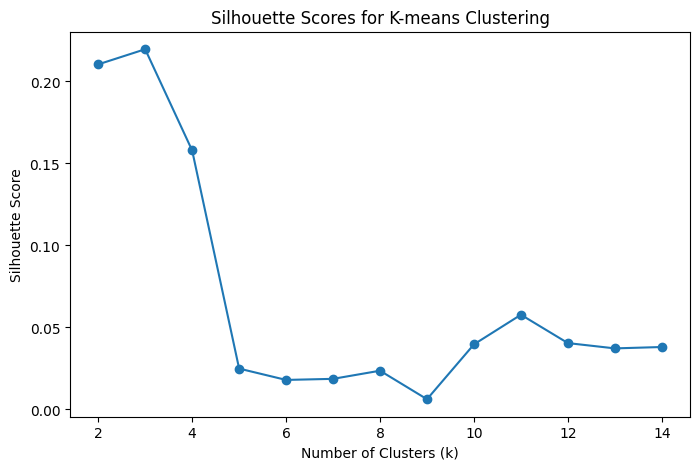

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, 15), silhouette_scores, marker="o")
plt.title("Silhouette Scores for K-means Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

In [8]:
# Choose best k based on highest silhouette score
# In case, the plot is illegible 
best_k = 2 + np.argmax(silhouette_scores)
best_labels, best_centers = kmeans_results[best_k]
best_sil = max(silhouette_scores)
print(f"Best k for K-means: {best_k}, Silhouette Score: {best_sil:.4f}")

Best k for K-means: 3, Silhouette Score: 0.2196


#### 5. DBSCAN Fallback

In [9]:
print("Trying DBSCAN to see if it forms better clusters...")
dbscan = DBSCAN(eps=0.5, min_samples=5, metric="euclidean")
dbscan_labels = dbscan.fit_predict(normalized_features)

# Check if DBSCAN found meaningful clusters (more than one cluster and no all -1)
if len(set(dbscan_labels)) > 1 and -1 not in set(dbscan_labels):
    dbscan_sil = silhouette_score(normalized_features, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_sil:.4f}")
    if dbscan_sil > best_sil:
        best_labels = dbscan_labels
        print("DBSCAN performed better than K-means. Using DBSCAN clusters.")
    else:
        print("K-means performed better, keeping K-means clusters.")
else:
    print("DBSCAN did not form better clusters. Keeping K-means result.")

Trying DBSCAN to see if it forms better clusters...
DBSCAN did not form better clusters. Keeping K-means result.


#### 6. PCA for Visualization

In [10]:
pca = PCA(n_components=2, random_state=SEED)
pca_features = pca.fit_transform(normalized_features)

#### 7. Visualize Clusters

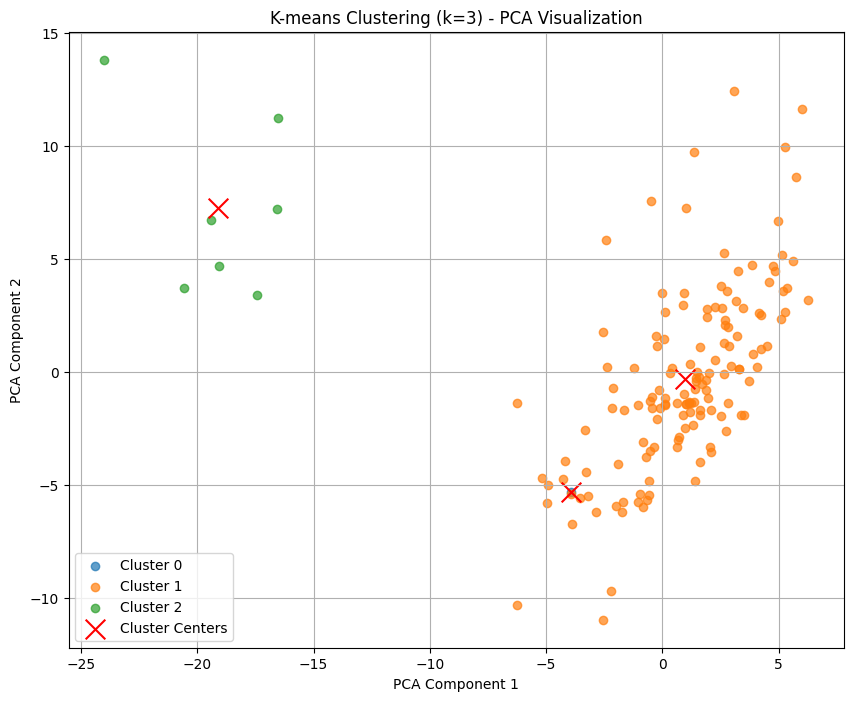

In [11]:
plt.figure(figsize=(10, 8))
for cluster_label in np.unique(best_labels):
    plt.scatter(pca_features[best_labels == cluster_label, 0],
                pca_features[best_labels == cluster_label, 1],
                label=f"Cluster {cluster_label}", alpha=0.7)

plt.scatter(pca.transform(best_centers)[:, 0], pca.transform(best_centers)[:, 1],
            marker="x", color='red', label='Cluster Centers', s=200)

plt.title(f"K-means Clustering (k={best_k}) - PCA Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

> Hope that in N-dimensional space the borders between classes are disinguishable with no any effort and that is the PCA that messed the plot up.

#### 8. Add Clusters to Items DataFrame

In [12]:
items = items.with_columns(
    pl.Series(best_labels).alias("kmeans_cluster")
)

#### 9. Save the Clustered Results

In [13]:
items.write_parquet("../data/processed/jokes_with_clusters.parquet")